# Tabular Playground Series - February 2022

For this months TPS, we are predicting the class of bacteria based on the histogram of DNA bases found in 10-mers of the DNA segments. We are told that our data includes simulated measurement errors.

In [1]:
import pandas as pd
import numpy as np
import pyarrow
import time
import re
import math

import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns; sns.set_theme()

In [2]:
from sklearn.preprocessing import LabelEncoder
from math import factorial
import gc

def prepare_data(path, integer = False, remove_dupes = True):
    
    # Load Data
    df = pd.read_csv(path)
    df = df.drop('row_id', axis = 1)
    features = [x for x in df.columns if x not in ['row_id','target']]
    bias = lambda w, x, y, z: factorial(10) / (factorial(w) * factorial(x) * factorial(y) * factorial(z) * 4**10)
    
    # Create integer data
    df_i = dict()
    for col in features:
        w = int(col[1:col.index('T')])
        x = int(col[col.index('T')+1:col.index('G')])
        y = int(col[col.index('G')+1:col.index('C')])
        z = int(col[col.index('C')+1:])
        df_i[col] = ((df[col] + bias(w, x, y, z)) * 1000000).round().astype(int) 
    df_i = pd.DataFrame(df_i)
    
    # Get GCDs
    gcd = df_i[features[0]]
    for col in features[1:]:
        gcd = np.gcd(gcd, df_i[col])
    df['gcd'] = gcd
    
    # Return integer histograms?
    if integer:
        df[features] = df_i[features]
    gc.collect()
        
    # Get sample weight
    if remove_dupes:
        vc = df.value_counts()
        df = pd.DataFrame([list(tup) for tup in vc.index.values], columns = df.columns)
        df['sample_weight'] = vc.values
    
    # Save Memory
    for col, dtype in df.dtypes.iteritems():
        if dtype.name.startswith('int'):
            df[col] = pd.to_numeric(df[col], downcast ='integer')
        elif dtype.name.startswith('float'):
            df[col] = pd.to_numeric(df[col], downcast ='float')
            
    return df

def load_data():
    try:
        # Successive notebook runs will load the preprocessed data locally
        train = pd.read_feather('../data/train.feather')
        test = pd.read_feather('../data/test.feather')
        submission = pd.read_csv('../data/sample_submission.csv')
    except:
        # First run has to perform preprocessing
        train = prepare_data('../data/train.csv')
        train.to_feather('../data/train.feather')
        test = prepare_data('../data/test.csv', remove_dupes = False)
        test.to_feather('../data/test.feather')
        submission = pd.read_csv('../data/sample_submission.csv')
    
    encoder = LabelEncoder()
    train['target'] = encoder.fit_transform(train['target'])
    
    return train, test, submission, encoder

# Load Data

In [3]:
%%time

train, test, submission, encoder = load_data()
target_bins = train['target'].astype(str) + train['gcd'].astype(str)

# Features
features = [x for x in train.columns if x not in ['row_id','target','sample_weight','gcd']]
print(f'Training Samples: {len(train)}')

Training Samples: 123993
CPU times: total: 1.67 s
Wall time: 307 ms


# Duplicate Data

Our training data contains many duplicate rows which have been combined and given a weight based on how often it was duplicated

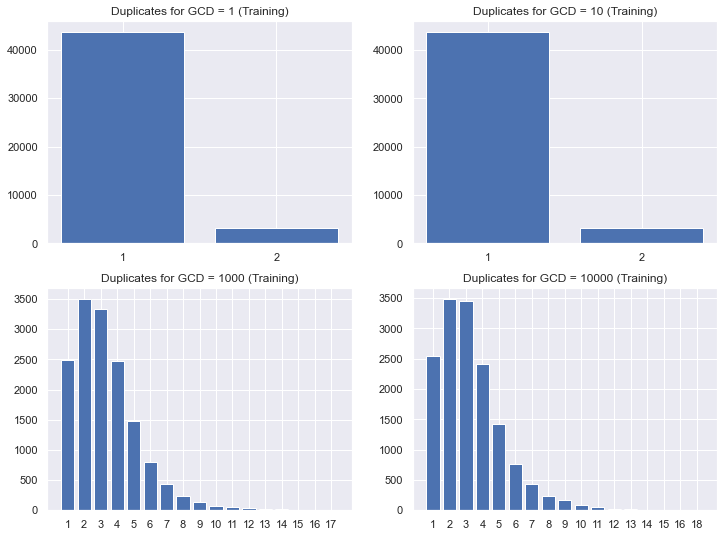

In [4]:
# Training Data Dupes
temp = train.groupby(['gcd','sample_weight'])['target'].count()
temp = temp.reset_index()
temp['sample_weight'] = temp['sample_weight'].astype('str')
fig, ax = plt.subplots(2, 2, figsize = (12,9))

gcd = [[1,10],[1000,10000]]

for row in range(2):
    for col in range(2):
        idx = 2*row + col
        ax[row,col].bar(
            temp[temp.gcd == gcd[row][col]]['sample_weight'], 
            temp[temp.gcd == gcd[row][col]]['target'],
        )
        ax[row,col].set_title(f'Duplicates for GCD = {gcd[row][col]} (Training)')

# Labels

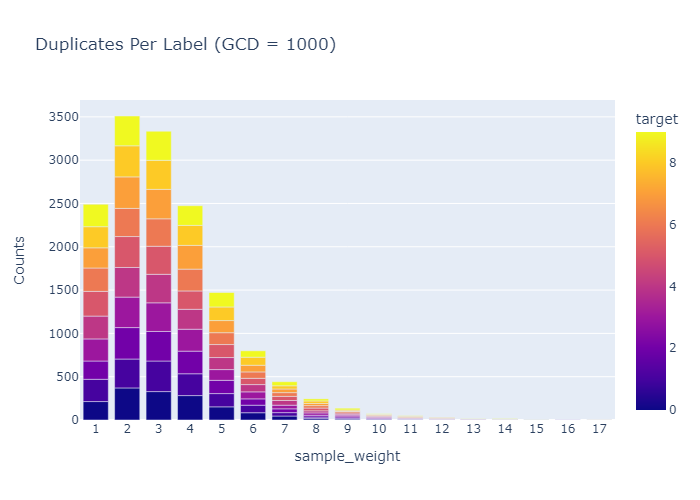

In [5]:
import plotly.express as px

# Training Data Dupes
temp = train.groupby(['gcd','sample_weight', 'target'])['A0T0G0C10'].count()
temp = temp.reset_index()
temp['sample_weight'] = temp['sample_weight'].astype('str')

fig = px.bar(
    temp[temp.gcd == 1000], x="sample_weight", y='A0T0G0C10', 
    color="target", title = "Duplicates Per Label (GCD = 1000)",
    labels = {'A0T0G0C10':'Counts'}
)
img_bytes = fig.to_image(format="png")
Image(img_bytes)

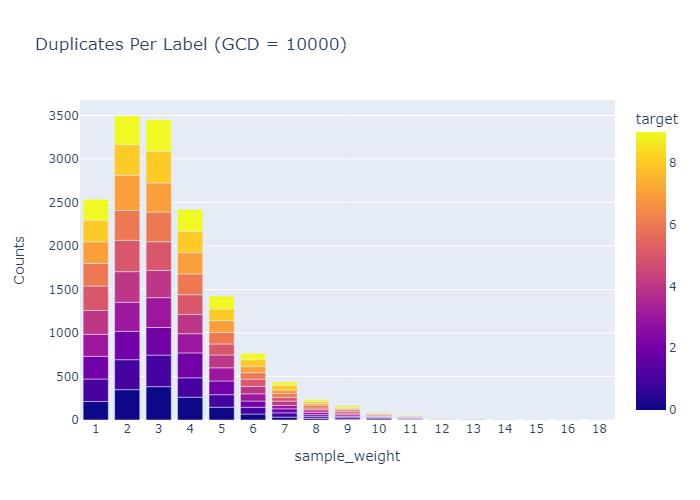

In [6]:

# Training Data Dupes
temp = train.groupby(['gcd','sample_weight', 'target'])['A0T0G0C10'].count()
temp = temp.reset_index()
temp['sample_weight'] = temp['sample_weight'].astype('str')

fig = px.bar(
    temp[temp.gcd == 10000], x="sample_weight", y='A0T0G0C10', 
    color="target", title = "Duplicates Per Label (GCD = 10000)",
    labels = {'A0T0G0C10':'Counts'}
)
img_bytes = fig.to_image(format="png")
Image(img_bytes)

# Test Data

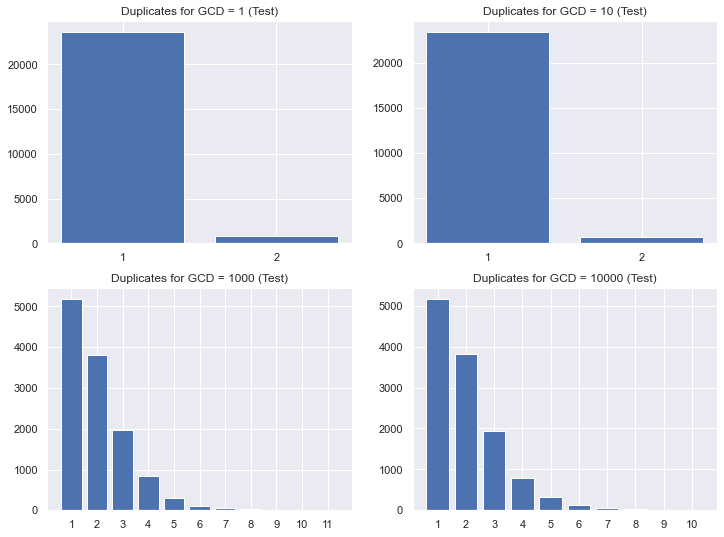

In [7]:
# Test Data dupes
temp = prepare_data('../data/test.csv')
temp = temp.groupby(['gcd','sample_weight'])['A0T0G0C10'].count()
temp = temp.reset_index()
temp['sample_weight'] = temp['sample_weight'].astype('str')
fig, ax = plt.subplots(2, 2, figsize = (12,9))

gcd = [[1,10],[1000,10000]]

for row in range(2):
    for col in range(2):
        idx = 2*row + col
        ax[row,col].bar(
            temp[temp.gcd == gcd[row][col]]['sample_weight'], 
            temp[temp.gcd == gcd[row][col]]['A0T0G0C10'],
        )
        ax[row,col].set_title(f'Duplicates for GCD = {gcd[row][col]} (Test)')

# Original Histograms

The training data is formed by creating histograms out of 10-mers, then subtracting off the "bias". The bias is the 10-mer count you would expect if you generated completely random DNA sequences. We then divide this unbiased count by the total number of 10-mers (1 million). Each row consists of different numbers of reads which are then multiplied by a constant so that their row sum is 1 million. 

In [8]:
%%time 

original_train = prepare_data('../data/train.csv', integer = True, remove_dupes = False)
original_test =  prepare_data('../data/test.csv', integer = True, remove_dupes = False)

print(f'Training Samples: {len(original_train)}')
print(f'Test Samples: {len(original_test)}')

original_train = original_train[original_train.gcd == 1][features].sum(axis = 0)
original_test = original_test[original_test.gcd == 1][features].sum(axis = 0) 
original_train //= 2

Training Samples: 200000
Test Samples: 100000
CPU times: total: 49.3 s
Wall time: 49.3 s


In [9]:
temp = original_train - original_test
temp.sort_values().head(20)

A2T3G2C3   -4180597
A3T3G2C2   -4121938
A4T2G2C2   -3741757
A3T2G2C3   -3641625
A2T4G2C2   -3523065
A3T2G3C2   -3437336
A2T3G3C2   -3365995
A3T4G1C2   -3298075
A3T3G3C1   -3230920
A4T3G2C1   -3161892
A4T4G1C1   -3155656
A2T2G3C3   -3148110
A4T3G1C2   -3136650
A3T3G1C3   -3123508
A5T2G2C1   -3084359
A3T4G2C1   -3064277
A2T5G1C2   -2947118
A4T1G3C2   -2701065
A4T2G3C1   -2674185
A3T5G1C1   -2577070
dtype: int64

# Correlation

We should expect a good deal of correlation since in counting the 10-mers there should be a lot of overlap, since shifting left or right will change at most two values by one.

In [10]:
corr_matrix = train[features].corr()
np.fill_diagonal(corr_matrix.values, 0)

<AxesSubplot:>

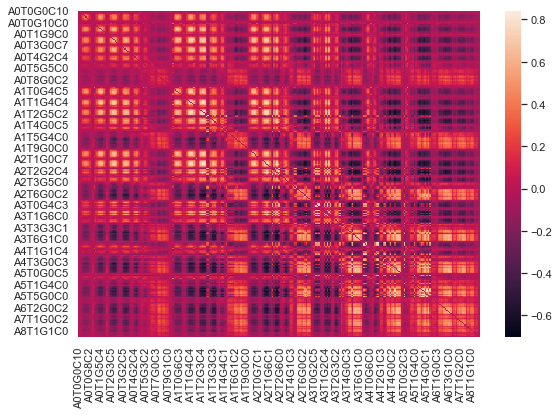

In [11]:
fig, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(corr_matrix, ax=ax)

# Principal Components

We can look at the principal components explained variance to see the redundancy.

Text(0.5, 0, '# of Components')

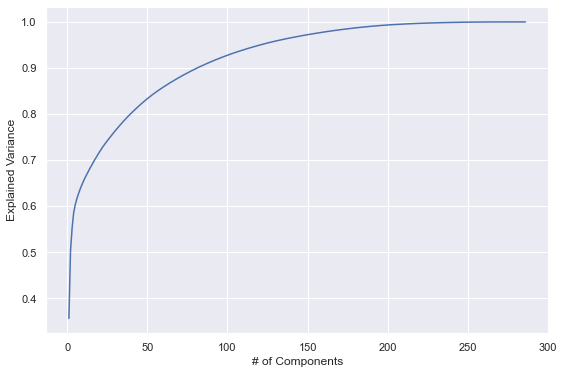

In [12]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(train[features])
cumsum = np.cumsum(pca.explained_variance_ratio_)

fig, ax = plt.subplots(figsize = (9,6))
ax.plot(range(1,len(cumsum)+1), cumsum)
plt.ylabel('Explained Variance')
plt.xlabel('# of Components')

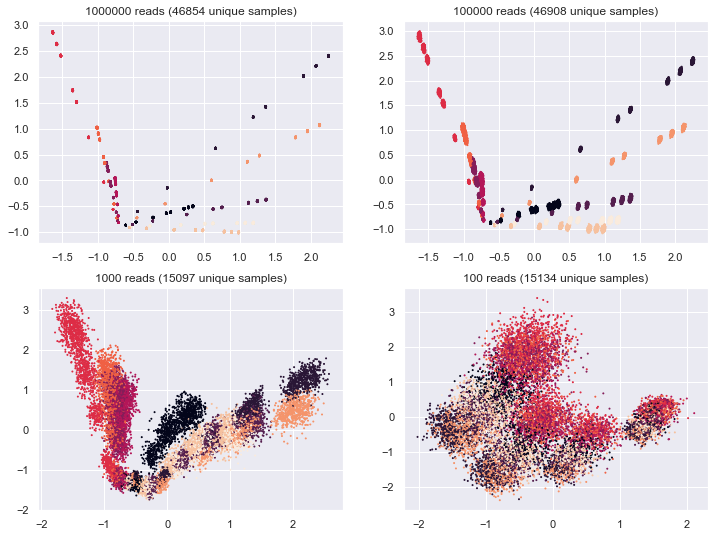

In [13]:
# Confusion matrix
fig, ax = plt.subplots(2, 2, figsize = (12,9))
GCD = [[1,10],[1000,10000]]

for row in range(2):
    for col in range(2):
        idx = 2*row + col
        gcd = GCD[row][col] 
        pca = PCA(whiten = True, random_state = 0)
        pca.fit(train[features][train.gcd == gcd])
        train_pca = pca.transform(train[features][train.gcd == gcd])
        ax[row,col].scatter(
            train_pca[:,0],train_pca[:,1],
            c = train[train.gcd == gcd]['target'], s = 1
        )
        ax[row,col].set_title(
            f"{1000000 // gcd} reads ({(train['gcd'] == gcd).sum()} unique samples)"
        )
plt.show()

# Test Data w/ PCA

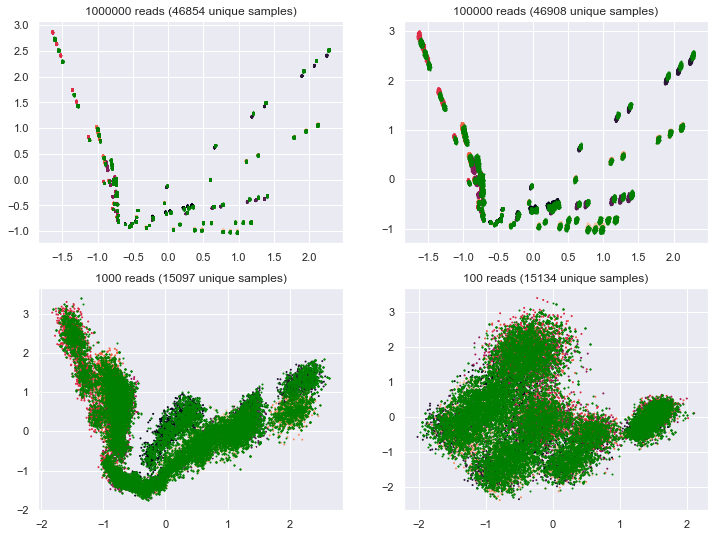

In [14]:
# Confusion matrix
fig, ax = plt.subplots(2, 2, figsize = (12,9))
GCD = [[1,10],[1000,10000]]

for row in range(2):
    for col in range(2):
        idx = 2*row + col
        gcd = GCD[row][col] 
        pca = PCA(whiten = True, random_state = 0)
        pca.fit(train[features][train.gcd == gcd])
        train_pca = pca.transform(train[features][train.gcd == gcd])
        test_pca = pca.transform(test[features][test.gcd == gcd])
        ax[row,col].scatter(
            train_pca[:,0],train_pca[:,1],
            c = train[train.gcd == gcd]['target'], s = 1
        )
        ax[row,col].scatter(
            test_pca[:,0],test_pca[:,1],
            c = 'green', s = 1
        )
        ax[row,col].set_title(
            f"{1000000 // gcd} reads ({(train['gcd'] == gcd).sum()} unique samples)"
        )
plt.show()